# Phase 4: Data Mining

## Imports, Helper Functions

In [5]:
from cProfile import label
from itertools import count
from statistics import mean
from turtle import color
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import psycopg2
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sqlalchemy import create_engine

country_codes = ['CAN', 'USA', 'MEX', 'IRN', 'THA', 'UKR', 'CAF', 'TCD', 'MLI']

countries_by_class_label = {
      'developed': ['CAN', 'USA'],
      'developing': ['MEX', 'IRN', 'THA', 'UKR'],
      'underdeveloped': ['CAF', 'TCD', 'MLI']
}

def get_country_development_class(country_code):
      if country_code in countries_by_class_label['developed']:
            return "developed"
      elif country_code in countries_by_class_label['developing']:
            return "developing"
      elif country_code in countries_by_class_label['underdeveloped']:
            return "underdeveloped"
      else:
            return np.NaN

def get_country_shape(country_code):
      if country_code in countries_by_class_label['developed']:
            return "s"
      elif country_code in countries_by_class_label['developing']:
            return "o"
      else:
            return "^"
      
def get_country_color(country_code):
      if country_code in countries_by_class_label['developed']:
            return "limegreen"
      elif country_code in countries_by_class_label['developing']:
            return "gold"
      else:
            return "red"

## Pulling Data from Dart Mart (PostgreSQL)

In [3]:
country_codes = ['CAN', 'USA', 'MEX', 'IRN', 'THA', 'UKR', 'CAF', 'TCD', 'MLI']

# SQL query to pull data from Postgres for data mining
query_pull_data = '''
SELECT DISTINCT 
       C.country_code, D.year_, 
       F.quality_of_life_index, F.human_development_index, F.income_index,
       C.total_population, C.population_growth, C.gdp_constant_2015, C.gdp_growth,
       ED.literacy_rate, ED.government_expenditure_on_education,
       H.birth_rate, H.death_rate, H.capital_health_expenditure, H.prevalence_of_overweight_female, H.prevalence_of_overweight_male, H.prevalence_of_hypertension_female, H.prevalence_of_hypertension_male,
       P.life_expectancy_female, P.life_expectancy_male, P.life_expectancy, P.net_migration, P.labor_force_total, P.unemployment_rate,
       LV.access_electricity, LV.coverage_social_insurance_programs, LV.access_to_fuels_for_cooking
FROM "CSI4142".fact_table as F, "CSI4142".country as C, "CSI4142".date_ as D, "CSI4142".education as ED, "CSI4142".health as H, "CSI4142".living_conditions as LV, "CSI4142".population_ as P
WHERE F.country_surrogate=C.surrogate_key AND
      F.date_surrogate=D.surrogate_key AND
      F.education_surrogate=ED.surrogate_key AND
      F.health_surrogate=H.surrogate_key AND
      F.living_conditions_surrogate=LV.surrogate_key AND
      F.population_surrogate=P.surrogate_key
ORDER BY C.country_code, D.year_
;
'''

# Pull data into dataframe
db_engine = create_engine('postgresql+psycopg2://bazzadev@localhost/bazzadev')
df = pd.read_sql_query(query_pull_data, db_engine)

## Data Summarization

In [6]:
def get_country_color(country_code):
      if country_code in countries_by_class_label['developed']:
            return "limegreen"
      elif country_code in countries_by_class_label['developing']:
            return "gold"
      else:
            return "red"

def boxplot_1(df):
      # fig = plt.figure()
      # ax = fig.add_subplot(111)
      plt.boxplot(
            [df[df['country_code']==code]['quality_of_life_index'] for code in country_codes], 
            labels=country_codes)
      plt.show()

def plot_1(df):
      countries = {}
      for code in country_codes:
          country_data = df[df['country_code']==code]
          countries[code] = country_data
          plt.plot(country_data['year_'], country_data['death_rate'], label=code)
      
      plt.legend(loc='lower left')
      plt.show()

def scatter_1(df):
      countries = {}
      for code in country_codes:
          country_data = df[df['country_code']==code]
          countries[code] = country_data
          plt.scatter(country_data['human_development_index'], country_data['prevalence_of_overweight_male'], label=code, marker=get_country_shape(code))
      
      plt.legend(loc='upper left')
      plt.show()

def hist_1(df):
      df.hist(bins=10)
      plt.show()

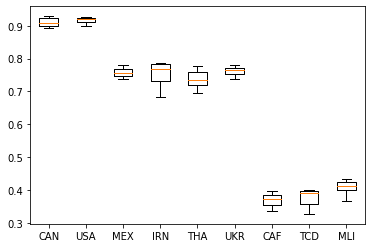

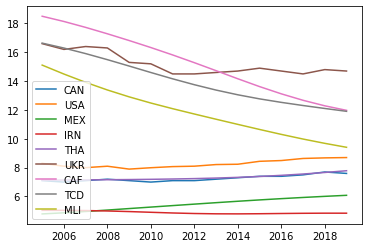

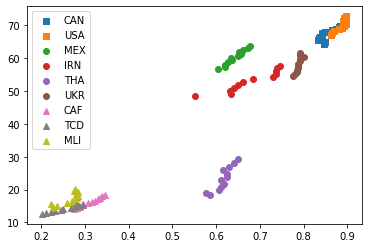

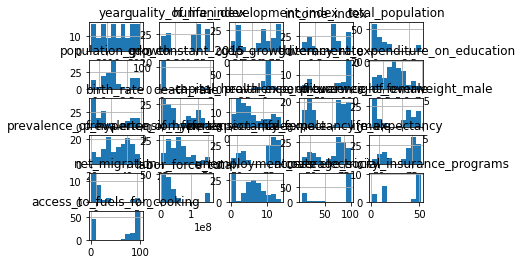

In [8]:
boxplot_1(df)
plot_1(df)
scatter_1(df)
hist_1(df)

## Data Pre-processing

In [9]:
df = df.fillna(method='pad', limit=3)
df = df.fillna(method='bfill', limit=3)

imp = SimpleImputer(missing_values=np.NaN, strategy='mean')

imp_cols = df.columns.to_list()[1:]
df[imp_cols] = pd.DataFrame(imp.fit_transform(df[imp_cols]))

df['development_class'] = df.apply(
      lambda row: get_country_development_class(row.country_code),
      axis=1)

df.insert(1, 'development_class', df.pop('development_class'))

le = LabelEncoder()
df['development_class'] = le.fit_transform(df['development_class'])

df.pop('country_code')
# df = pd.get_dummies(df)
df.pop('human_development_index')
df.pop('quality_of_life_index')
df.pop('income_index')

feature_cols = df.columns.to_list()[1:]
label = 'development_class'

df[feature_cols] = pd.DataFrame(
      MinMaxScaler().fit_transform(df[feature_cols]), 
      columns=feature_cols)

X = df[feature_cols]
y = df[label]

print(X)
print(y)

        year_  total_population  population_growth  gdp_constant_2015  \
0    0.000000          0.000000           0.615086           0.000011   
1    0.066667          0.000245           0.613102           0.000015   
2    0.133333          0.000490           0.605827           0.000019   
3    0.200000          0.000722           0.573193           0.000021   
4    0.266667          0.000919           0.507733           0.000030   
..        ...               ...                ...                ...   
139  0.733333          0.980297           0.332555           0.928698   
140  0.800000          0.986597           0.311556           0.950364   
141  0.866667          0.991870           0.287322           0.978844   
142  0.933333          0.996454           0.271110           1.000000   
143  1.000000          1.000000           0.247273           0.965951   

     gdp_growth  literacy_rate  government_expenditure_on_education  \
0      0.694286       0.586394                      

## Classification

In [10]:
def train_and_test(X, y, model, modelName = "Some Model"):
      X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.30, test_size=0.70, random_state=1)
      
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)
      
      print(modelName, '\n--------------------------------')
      print(f'model score on training data: {model.score(X_train, y_train)}')
      print(f'model score on testing data: {model.score(X_test, y_test)}')
      print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
      print("Precision:", metrics.precision_score(y_test, y_pred, average="macro"))
      print("Recall:", metrics.recall_score(y_test, y_pred, average="macro"))

      print("Feature Importance: ")
      print(model.feature_importances_)
      print('\n ')
      
      importances = model.feature_importances_
      indices = np.argsort(importances)

      fig, ax = plt.subplots()
      ax.barh(range(len(importances)), importances[indices])
      ax.set_yticks(range(len(importances)))
      _ = ax.set_yticklabels(np.array(X_train.columns)[indices])
      plt.show()

Decision Tree Classifier 
--------------------------------
model score on training data: 1.0
model score on testing data: 0.9504950495049505
Accuracy: 0.9504950495049505
Precision: 0.9321475625823452
Recall: 0.9552452559971357
Feature Importance: 
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.4869338 0.        0.5130662 0.        0.        0.        0.
 0.        0.       ]

 


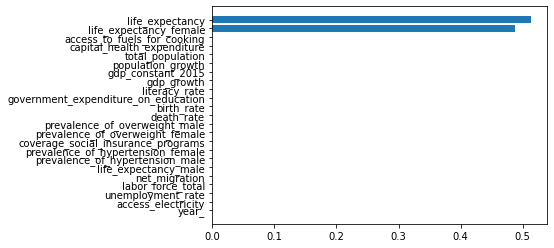

Gradient Boosting Classifier 
--------------------------------
model score on training data: 1.0
model score on testing data: 0.9504950495049505
Accuracy: 0.9504950495049505
Precision: 0.9566993464052288
Recall: 0.9593898165326737
Feature Importance: 
[0.00000000e+00 4.61777599e-02 8.11962159e-03 3.64075404e-02
 0.00000000e+00 3.06451491e-01 0.00000000e+00 1.23338471e-01
 8.48274588e-07 3.15303930e-07 8.91378837e-08 3.93635301e-10
 3.65477344e-08 2.12650899e-02 7.25845352e-02 5.74914366e-02
 7.96794147e-02 1.04395919e-01 2.14638791e-04 0.00000000e+00
 9.72088540e-02 2.27063143e-03 4.43933062e-02]

 


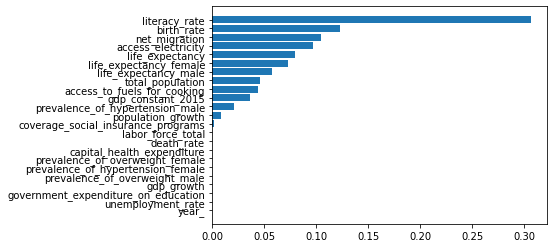

Random Forest Classifier 
--------------------------------
model score on training data: 1.0
model score on testing data: 1.0
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Feature Importance: 
[0.0006503  0.05837327 0.00430178 0.12148818 0.00066128 0.04402696
 0.00888034 0.04663051 0.01278213 0.04768649 0.01770065 0.04832974
 0.00773175 0.         0.06810156 0.08333704 0.14276842 0.07641438
 0.03821612 0.00231806 0.03049396 0.         0.13910705]

 


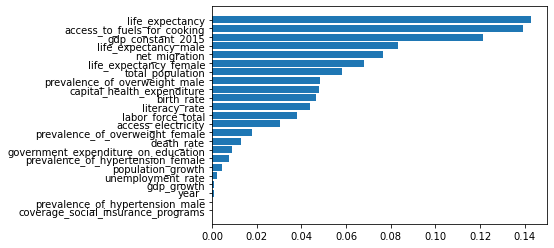

In [11]:
train_and_test(X, y, DecisionTreeClassifier(), "Decision Tree Classifier")
train_and_test(X, y, GradientBoostingClassifier(), "Gradient Boosting Classifier")
train_and_test(X, y, RandomForestClassifier(), "Random Forest Classifier")